### Лабораторная работа 2


### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии
- реализуете логистическую регрессию и её обучение градиентным спуском
- настроите метод опорных векторов, визуализируете опорные вектора
- познакомитесь с калибровочными кривыми и сравните вероятности, выдаваемые логистической регрессией и методом опорных векторов
- изучите методы работы с категориальными переменными

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Линейная регрессия

В этой части мы кратко познакомимся с линейной регрессией.

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3.

In [2]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

__Задание 1.__ Обучение линейной регрессии.



Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$). Согласуются ли результаты с вашими ожиданиями?

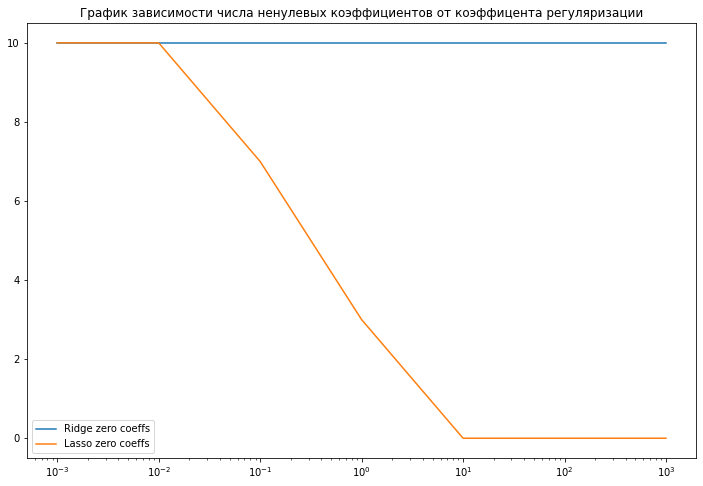

In [3]:
from sklearn.linear_model import Ridge, Lasso

lambdas = np.logspace(-3, 3, 7)
ridge = []
lasso = []

for lmbd in lambdas:
  ridge_coefs = Ridge(lmbd).fit(X_train, y_train).coef_
  ridge_coefs[np.abs(ridge_coefs) < 1e-3] = 0
  lasso_coefs = Lasso(lmbd).fit(X_train, y_train).coef_
  lasso_coefs[np.abs(lasso_coefs) < 1e-3] = 0

  ridge.append(len(ridge_coefs[ridge_coefs != 0]))
  lasso.append(len(lasso_coefs[lasso_coefs != 0]))

plt.title("График зависимости числа ненулевых коэффициентов от коэффицента регуляризации")
plt.plot(lambdas, ridge, label="Ridge zero coeffs")
plt.plot(lambdas, lasso, label="Lasso zero coeffs")
plt.legend()
plt.semilogx()
plt.show()

Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

ridge =  Ridge().fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("RMSE:\t", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:\t", mean_absolute_error(y_test, y_pred))
print("R2:\t", r2_score(y_test, y_pred))

RMSE:	 58.304415127748044
MAE:	 49.602846072752996
R2:	 0.3598993868368464


Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Для этого воспользуйтесь GridSearchCV и KFold из sklearn. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

In [5]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(Ridge(), {"alpha": lambdas}).fit(X_train, y_train)
best_lmbd = search.best_params_["alpha"]

ridge =  Ridge(best_lmbd).fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("RMSE:\t", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:\t", mean_absolute_error(y_test, y_pred))
print("R2:\t", r2_score(y_test, y_pred))

RMSE:	 55.85776764051338
MAE:	 47.15555064391418
R2:	 0.4124937282832306


**Выводы:** Качество немного улучшилось: значение метрик RMSE и MAE стало меньше, а значение метрики $R^2$ повысилось, что говорит о том, что после подбора коэффициента регуляризации модель стала объяснять большую долю дисперсии.

__Задание 2.__ Поиск объектов-выбросов



Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. С помощью cross_val_predict сделайте Out-of-Fold предсказания для обучающей выборки. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

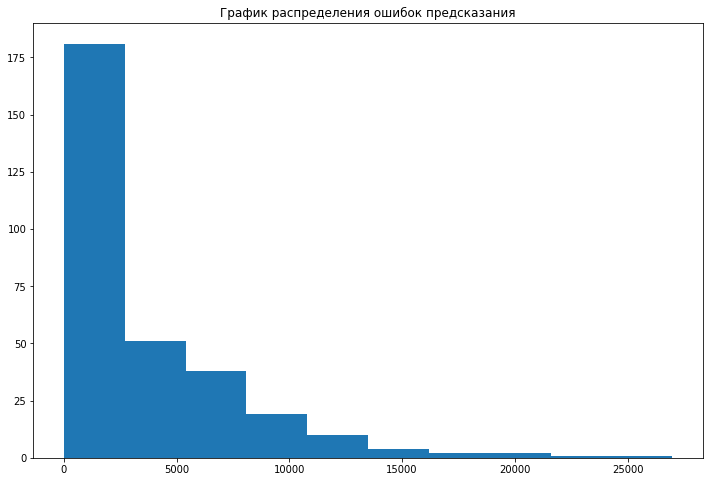

In [6]:
from sklearn.model_selection import cross_val_predict

predicted = cross_val_predict(Ridge(), X_train, y_train, cv=10)

plt.title("График распределения ошибок предсказания")
plt.hist((y_train - predicted) ** 2)
plt.show()

**Выводы:** Видим, что у распределения тяжёлый хвост, то есть в выборке имеется достаточное число объектов, ошибка предсказания на которых довольно велика (выше чем 10000). Будем считать все такие объекты выбросами.

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

In [7]:
mask = ((y_train - predicted) ** 2) < 1e4

y_pred = Ridge().fit(X_train, y_train).predict(X_test)
print("MSE до удаления выбросов:\t", mean_squared_error(y_test, y_pred))
y_pred = Ridge().fit(X_train[mask, :], y_train[mask]).predict(X_test)
print("MSE после удаления выбросов:\t", mean_squared_error(y_test, y_pred))

MSE до удаления выбросов:	 3399.4048233887747
MSE после удаления выбросов:	 3590.2174712704737


**Выводы:** Стало хуже. Вероятно дело в том, что мы удалили то, что считаем выбросами только из обучающей выборки, но в тестовой они остались. До удаления выбросов модель хотя бы примерно понимала, какие предсказания для них стоит выдавать. Теперь же для неё это совершенно новые объекты.

## Часть 2. Логистическая регрессия

В этой части мы будем реализовывать один из самых простых бинарных классификаторов — логистическую регрессию и её обучение с помощью обычного (полного) и стохастического градиентных спусков.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). В случае стохастического градиентного спуска $\nabla_w Q(w, X) \approx \nabla_w q_{i_k} (w)$, где $i_k$ — случайно выбранный номер слагаемого из функционала (регуляризатор можно внести в сумму, предварительно умножив и разделив на $l$). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Формулу для градиента функции потерь логистической регрессии вы должны были выводить в рамках одной из задач четвёртого теоретического домашнего задания. Но на всякий случай мы её повторим. Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Вероятность принадлежности объекта $x$ классу $+1$ вычисляется следующим образом:

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- \langle w, x \rangle )}
$$

Не забывайте, что матрицу объекты-признаки $X$ необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из 2 способов, разобранных на лекциях). Для этого можно воспользоваться StandardScaler или сделать это вручную.

В логистической регрессии также можно использовать $L_1$-регуляризацию. Тогда в функцию потерь добавится слагаемое $\lambda_1 \lVert w \rVert _1$. В формуле для вычисления градиента фукнции потерь по вектору коэффициентов это слагаемое будет соответствовать $\lambda_1 sgn(w)$, где $sgn$ — вычисление знака числа, применяемое к вектору коэффициентов поэлементо.

__Задание 1.__ Реализация обучения и применения логистической регресии c $L_2$-регуляризацией. 



Используйте для этого указанные ниже прототипы. Для эффективности все вычисления производите в векторизованной форме без циклов (кроме самих итераций градиентного спуска). Сгенерируйте с помощью функции make\_classification из модуля sklearn.datasets небольшую выборку для тестирования и исследования (выборка не должна быть слишком простой для классификации; также не забудьте проверить, что метки объектов из необходимого нам множества). Постройте следующие графики (для полного и стохастического градиентного спуска на одном графике):
- функции потерь от номера итерации обучения
- затраченного времени от номера итерации обучения

Возьмите параметр регуляризации $\lambda_2=1$, точность $tolerance=10^{-6}$, максимальное число итераций $max\_iter=1000$. Подберите оптимальную на ваш взгляд величину шага градиентного спуска. 

Сделайте выводы о том, чем различается на практике обучение с помощью стохастического градиентного спуска по сравнению с полным градиентным спуском.

В этом задании не обращайте внимания на $\lambda_1$, соответствующий $L_1$-регуляризации.

Для численной устойчивости вам могут быть полезны функции: scipy.special.expit и numpy.logaddexp.

__Важно:__ код с реализацией логистической регрессии необходимо также отправить на проверку в Яндекс.контест (ссылка [раз](https://official.contest.yandex.ru/contest/5704/problems/) и [альтернативная](https://contest.yandex.ru/contest/5704/problems/)). Не забывайте про pep8. 

ID посылки: ...

__Бонусное задание.__ Реализация $L_1$-регуляризации и обучение с помощью субградиентного спуска.

__(1.0 балла)__

Модифицируйте реализацию так, чтобы можно было обучать логистическиую регрессию с $L_1$-регуляризацией (и даже одновременно с двумя видами). Проведите аналогичные эксперименты, считая $\lambda_1 = 0.001, \lambda_2 = 0$.

Стоит помнить, что модуль — недифференцируемая в нуле функция, поэтому мы не можем применить обычный градиентный спуск. Вместо этого будем применить субградиентный спуск — аналогичный градиентному спуску метод, в котором используется субградиент функции. 

Вектор $g \in \mathbb{R}$ называется субградиентом выпуклой функции $f$ в точке $x$, если $\forall z \in \mathbb{R}$ выполнено неравенство: $f(z) \ge f(x) + g^T (z-x)$. Если функция $f$ дифференцируема в точке $x$, её субградиент в этой точке совпадает с градиентом. Субдифференциалом функции $f$ называют множество субградиентов в этой точке.

Для $f(x) = |x|$ при $x = 0$ субдифференциал определяется неравенством $|z| \ge gz$, поэтому $g \in [-1, 1]$. 

На практике для стабильности процесса обучения для близких к нулю значений можно уменьшать градиент, умножая на небольшое число (например, 0.1-0.5) или делая его нулевым (только околонулевые координаты!)

In [8]:
from scipy.special import expit
from time import time

class LogReg(BaseEstimator):
    def __init__(self, lambda_1=0.0, lambda_2=1.0, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        self.w = self.w0
        iters = 0
        start = time()
        while iters < self.max_iter:
          grad = self.calc_gradient(X, y)
          
          self.w0 = np.copy(self.w)
          self.w -= self.alpha * grad

          self.loss_history.append([self.calc_loss(X, y), time() - start])

          if np.linalg.norm(self.w - self.w0) < self.tolerance:
            break
          iters += 1

        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')

        pos_proba = expit(X @ self.w).reshape(-1, 1)
        return np.hstack([1 - pos_proba, pos_proba])
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        if self.gd_type == "full":
            grad = 1/X.shape[0] * (-y * expit(-y * (X @ self.w))).T @ X + self.lambda_1 * np.sign(self.w) + self.lambda_2 * self.w
        else:
            i = np.random.randint(0, X.shape[0])
            x_i = X[i, :]
            y_i = y[i]
            grad = -y_i * x_i * expit(-y_i * x_i @ self.w) + self.lambda_1 * np.sign(self.w) + self.lambda_2 * self.w

        if self.lambda_1 != 0:
          grad[np.abs(grad) < 1e-3] = 0
        
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        return np.mean(np.log(np.ones_like(y) + np.exp(-y * (X @ self.w))) + self.lambda_2 / 2 * self.w @ self.w)

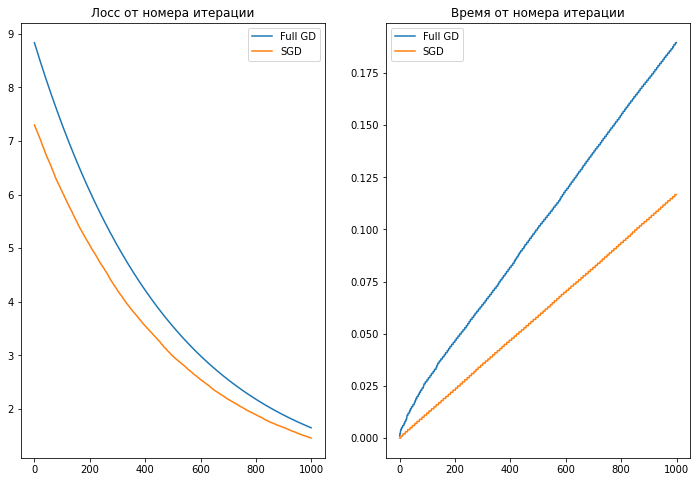

In [9]:
from sklearn.datasets import make_classification

# dataset1.csv
X, y = make_classification(1000, 10, random_state=228)

logreg_full = LogReg(gd_type="full", tolerance=1e-6, w0 = np.random.randn(X.shape[1]))
logreg_full.fit(X, y)
logreg_full.loss_history = np.array(logreg_full.loss_history)
logreg_sgd = LogReg(tolerance=1e-6, w0 = np.random.randn(X.shape[1]))
logreg_sgd.fit(X, y)
logreg_sgd.loss_history = np.array(logreg_sgd.loss_history)

plt.subplot(121)
plt.title("Лосс от номера итерации")
plt.plot(logreg_full.loss_history[:, 0], label="Full GD")
plt.plot(logreg_sgd.loss_history[:, 0], label="SGD")
plt.legend()
plt.subplot(122)
plt.title("Время от номера итерации")
plt.plot(logreg_full.loss_history[:, 1], label="Full GD")
plt.plot(logreg_sgd.loss_history[:, 1], label="SGD")
plt.legend()
plt.show()

__Выводы:__ полный градиентный спуск должен давать лучший лосс, чем SGD, т.к. в этом случае в градиенте содержится информация обо всей выборке, а не об одном объекте, но и работать полный спуск должен дольше.

Проведём аналогичные эксперименты для логрега с $L_1$ регуляризацией:

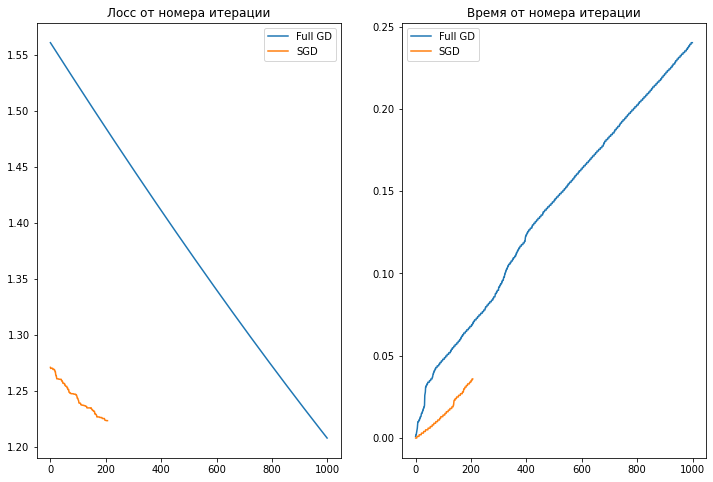

In [10]:
from sklearn.datasets import make_classification

# dataset2.csv
X, y = make_classification(1000, 10,random_state=320)

logreg_full = LogReg(lambda_1 = 1e-3, lambda_2 = 0, gd_type="full", tolerance=1e-6, w0 = np.random.randn(X.shape[1]))
logreg_full.fit(X, y)
logreg_full.loss_history = np.array(logreg_full.loss_history)
logreg_sgd = LogReg(lambda_1 = 1e-3, lambda_2 = 0, tolerance=1e-6, w0 = np.random.randn(X.shape[1]))
logreg_sgd.fit(X, y)
logreg_sgd.loss_history = np.array(logreg_sgd.loss_history)

plt.subplot(121)
plt.title("Лосс от номера итерации")
plt.plot(logreg_full.loss_history[:, 0], label="Full GD")
plt.plot(logreg_sgd.loss_history[:, 0], label="SGD")
plt.legend()
plt.subplot(122)
plt.title("Время от номера итерации")
plt.plot(logreg_full.loss_history[:, 1], label="Full GD")
plt.plot(logreg_sgd.loss_history[:, 1], label="SGD")
plt.legend()
plt.show()

__Задание 2.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.



Полезные функции и классы из scikit-learn для этого задания: confusion_matrix, precision_recall_curve, average_precision_score, train_test_split, StandardScaler, roc-curve, roc_auc_score.

Загрузим данные с актуального сейчас конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [11]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [12]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучите логистическую регрессию с удобными для вас параметрами. Сделайте предсказание на тестовой части выборки.

In [14]:
log_reg = LogReg(tolerance=1e-6, w0 = np.random.randn(X_train.shape[1]))
log_reg.fit(X_train, y_train)
y_proba = log_reg.predict_proba(X_test)

Постройку ROC-кривую (график зависимости числа ложных срабатываний от истинного положительного значения) и Precision-Recall-кривую, посчитайте ROC-AUC и PR-AUC. Какие наблюдения и выводы по ним можно сделать? (В свободной форме)

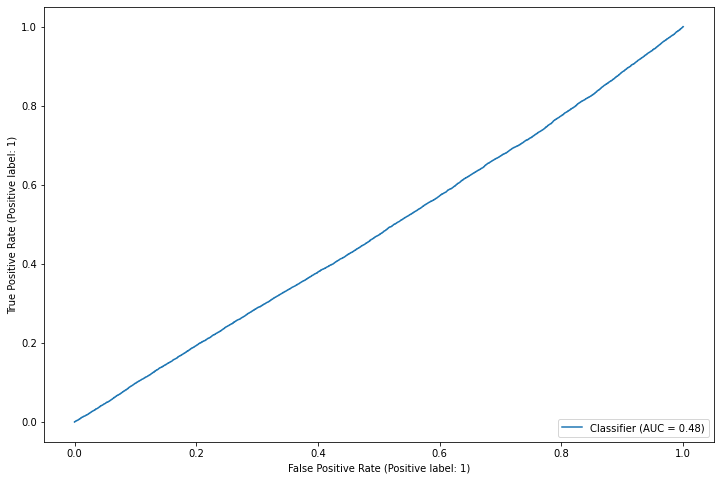

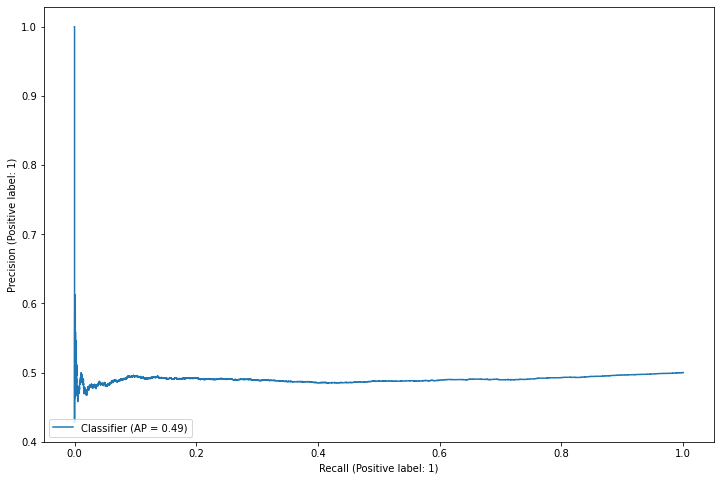

In [15]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_proba[:, 1])
PrecisionRecallDisplay.from_predictions(y_test, y_proba[:, 1])
plt.show()

**Выводы:** AUC-ROC на уровне 50%, значит, наш классификатор не слишком отличается от случайного классификатора.

Предположим, что наш алгоритм должен обеспечивать полноту не менее 0.7. Какому порогу бинаризации вероятностей это будет соответствовать? Какую точность (precision) мы получим? Постройте матрицу ошибок для данного порога. Что вы можете сказать о таком алгоритме? (В свободной форме)

In [16]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, confusion_matrix

def set_tres(proba, tres):
  preds = np.copy(proba)
  preds[preds > tres] = 1
  preds[preds <= tres] = 0
  return preds

pred = set_tres(y_proba[:, 1], 0.24)
print("Полнота предсказаний:\t", recall_score(y_test, pred))
print("Точность предсказаний:\t", precision_score(y_test, pred))
print("\nМатрица ошибок:")
(tn, fp), (fn, tp) = confusion_matrix(y_test, pred)
print(f"TN={tn}\tFP={fp}")
print(f"FN={fn}\tTP={tp}")

Полнота предсказаний:	 0.6512818461784586
Точность предсказаний:	 0.490533640594641

Матрица ошибок:
TN=16169	FP=33825
FN=17438	TP=32568


**Выводы:** Как и было сказано ранее, хоть мы и классифицируем верно 70% всех положительных объектов выборки, точность такого алгоритма на уровне генератора случайных чисел.

__Задание 3.__ Изучение влияния регуляризатора на процесс обучения



Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

In [26]:
log_reg_0 = LogReg(lambda_2 = 0, tolerance=1e-6, w0 = np.random.randn(X_train.shape[1]), max_iter=1)
log_reg_a = LogReg(lambda_2 = 1e-3, tolerance=1e-6, w0 = np.random.randn(X_train.shape[1]), max_iter=1)
loss_0 = []
loss_a = []

for i in range(1000):
  log_reg_0.fit(X_train, y_train)
  log_reg_0.w0 = log_reg_0.w
  log_reg_a.fit(X_train, y_train)
  log_reg_a.w0 = log_reg_a.w
  loss_0.append([log_reg_0.loss_history[0][0], log_reg_0.calc_loss(X_test, y_test)])
  loss_a.append([log_reg_a.loss_history[0][0], log_reg_a.calc_loss(X_test, y_test)])

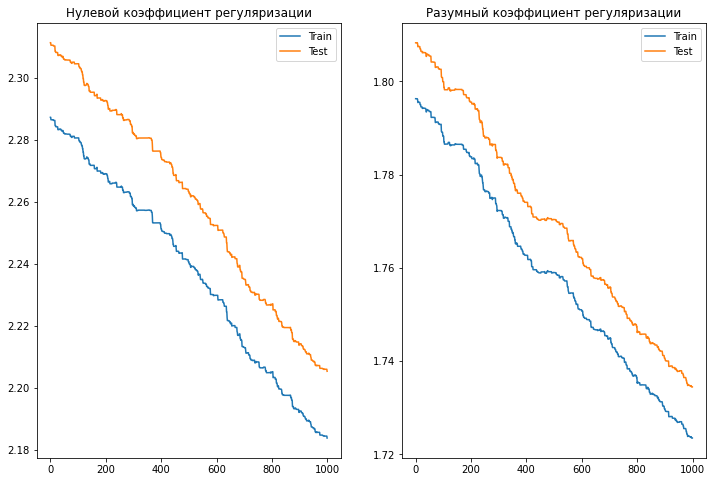

In [27]:
loss_0 = np.array(loss_0)
loss_a = np.array(loss_a)

plt.subplot(121)
plt.title("Нулевой коэффициент регуляризации")
plt.plot(loss_0[:, 0], label="Train")
plt.plot(loss_0[:, 1], label="Test")
plt.legend()
plt.subplot(122)
plt.title("Разумный коэффициент регуляризации")
plt.plot(loss_a[:, 0], label="Train")
plt.plot(loss_a[:, 1], label="Test")
plt.legend()
plt.show()

**Выводы:** Если добавить регуляризацию, то кроме того что лосс получается ниже, так ещё и график лосса становится более монотонным на обеих выборках.

## Часть 3. Метод опорных векторов и калибровка вероятностней

__Задание 1.__ Обучение и применение метода опорных векторов.



Обучите метод опорных векторов (в этот раз воспользуйтесь готовой реализацией LinearSVC из sklearn). Используйте уже загруженные и обработанные в предыдущей части данные.

In [19]:
from sklearn.svm import LinearSVC

svm = LinearSVC().fit(X_train, y_train)
y_proba = svm.predict(X_test)

C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


На той же тестовой части посчитайте все те же метрики. Что вы можете сказать о полученных результатах?

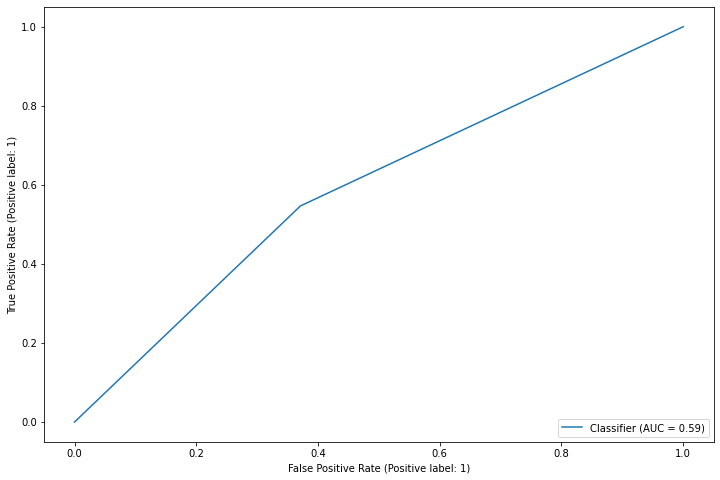

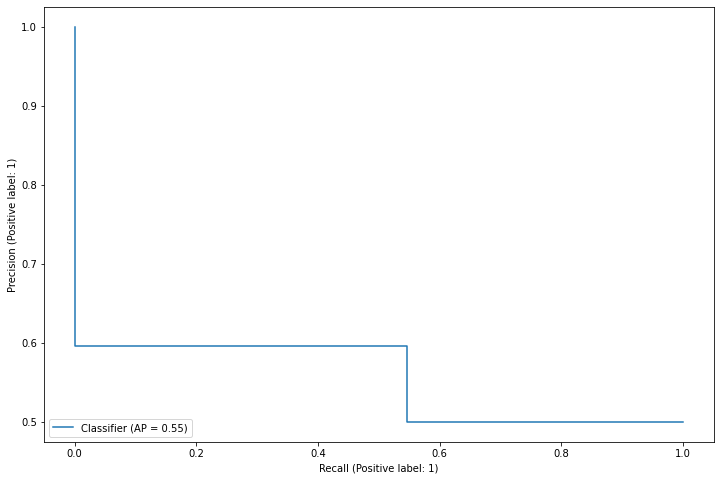

In [20]:
RocCurveDisplay.from_predictions(y_test, y_proba)
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.show()

**Выводы:** SVM работает лучше, чем логрег (ROC-AUC 0.6), но всё ещё довольно посредственно.

В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов с линейным ядром. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром, так как только в нём есть информация об опорных векторах.

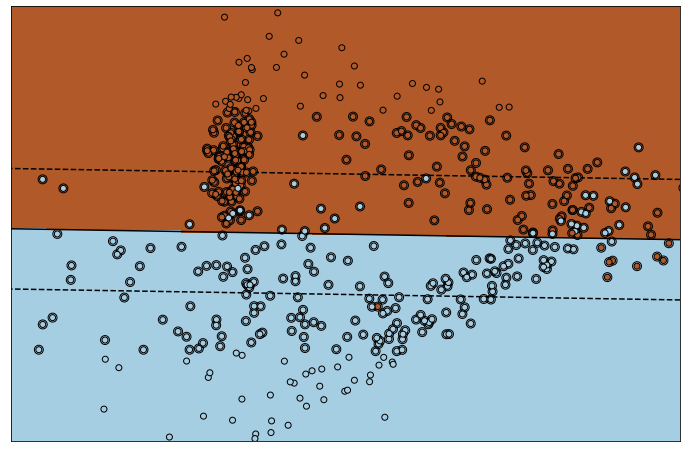

In [21]:
# dataset3.csv
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=322)

from sklearn.svm import SVC

Cs = np.logspace(-4, 2, 10)
err = 0
svm_C = 0

for C in Cs:
  svc = SVC(C=C, kernel='linear').fit(X, y)
  svc_pred = svc.decision_function(X)
  if average_precision_score(y, svc_pred) > err:
    err = average_precision_score(y, svc_pred)
    svm_C = C

svc = SVC(kernel='linear', C=svm_C).fit(X, y)

# plot the line, the points, and the nearest vectors to the plane
plt.clf()

plt.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s=80,
    facecolors="none",
    zorder=10,
    edgecolors="k",
)
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolors="k")

plt.axis("tight")
x_min = -3
x_max = 3
y_min = -3
y_max = 3

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = svc.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(
    XX,
    YY,
    Z,
    colors=["k", "k", "k"],
    linestyles=["--", "-", "--"],
    levels=[-0.5, 0, 0.5],
)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())
plt.show()

__Задание 2.__ Калибровка вероятностей.



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [22]:
def plot_calibration_curve(y_test, preds, label=""):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.plot(bin_middle_points, bin_real_ratios, label=label)
    plt.grid()

Посмотройте калибровочные кривые для логистической регрессии и метода опорных векторов (на той же самой выборке с тем же самым разбиением — можно использовать уже полученные ранее предсказания). Изучите распределение ответов классификаторов (постройте гистограммы с помощью plt.hist). Чем они различаются? Чем вы можете объяснить это?

Заметим, что метод опорных векторов не умеет predict_proba, но имеет метод decision_function.

C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


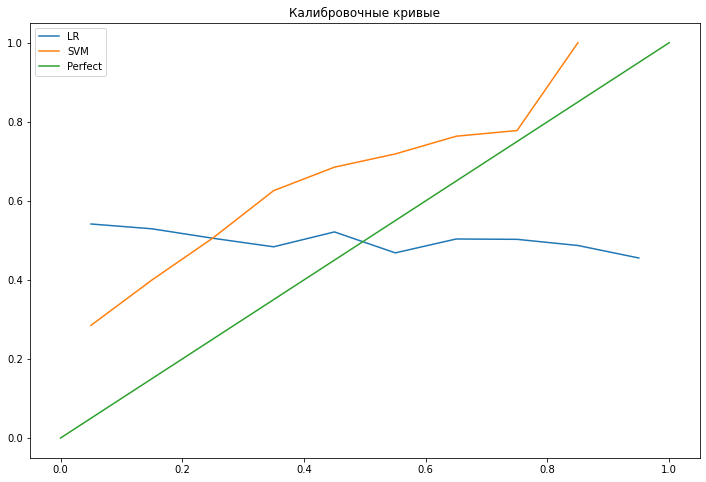

In [23]:
lr = LogReg(lambda_2=0, w0 = np.random.randn(X_train.shape[1])).fit(X_train, y_train)
svc = LinearSVC(loss="hinge")

y_pred_lr = lr.predict_proba(X_test)[:,1]
y_pred_svc = svc.fit(X_train, y_train).decision_function(X_test)
y_pred_svc = (y_pred_svc - y_pred_svc.min()) / (y_pred_svc.max() - y_pred_svc.min())
plt.title("Калибровочные кривые")
plot_calibration_curve(y_test, y_pred_lr, "LR")
plot_calibration_curve(y_test, y_pred_svc, "SVM")
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), label="Perfect")
plt.legend()
plt.show()

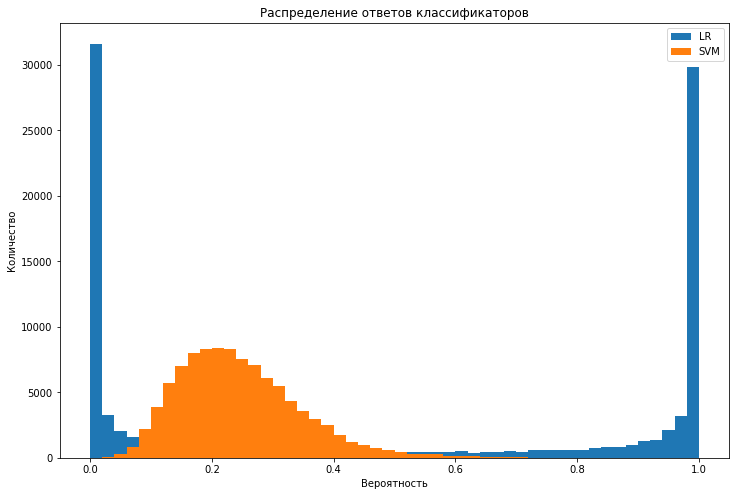

In [24]:
plt.hist(y_pred_lr, bins=50, label="LR")
plt.hist(y_pred_svc, bins=50, label="SVM")
plt.title("Распределение ответов классификаторов")
plt.xlabel("Вероятность")
plt.ylabel("Количество")
plt.legend()
plt.show()

**Выводы:** Логистическая регрессия придумана так, чтобы корректно оценивать вероятность принадлежности объектов к положительному классу. Метод опорных векторов составлен из других соображений, и оценивать вероятности не умеет. Поэтому ответы лог регрессии часто могут быть около 0 или 1, а SVM в этом плане более неуверенный: он концентрирует свои ответы около 0.5. Это не значит, что это плохой классификатор, просто он не умеет оценивать вероятности.

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\microb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

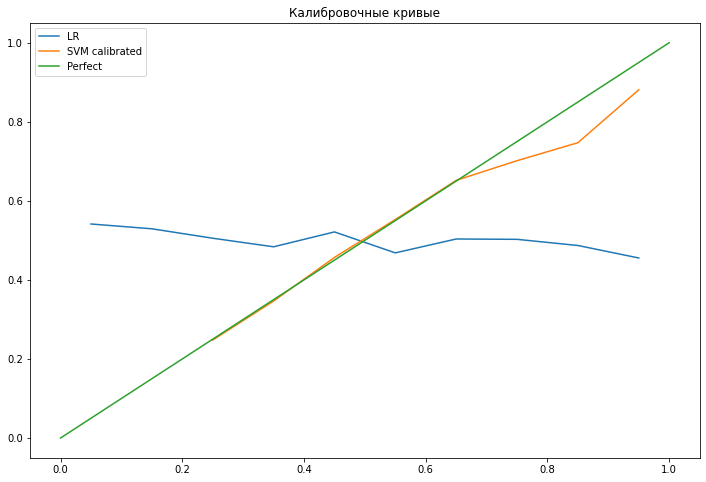

In [29]:
from sklearn.calibration import CalibratedClassifierCV

svc_calibrated_platt = CalibratedClassifierCV(svc, cv=5, method="sigmoid").fit(X_train, y_train)
y_pred_svc_platt = svc_calibrated_platt.predict_proba(X_test)[:, 1]

plt.title("Калибровочные кривые")
plot_calibration_curve(y_test, y_pred_lr, "LR")
plot_calibration_curve(y_test, y_pred_svc_platt, "SVM calibrated")
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), label="Perfect")
plt.legend()
plt.show()

**Выводы:** После калибровки кривая SVM стала ближе к кривой логрега (которая, как написано выше, умеет оценивать вероятности). Можно сделать вывод, что калибровка улучшила кривую SVM.

## Часть 4. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.



In [30]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [31]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from time import time

categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
numerical_features =  X_train.select_dtypes([np.int64, np.float64]).columns

logreg = LogReg(tolerance=1e-6, w0 = np.random.randn(X_train.shape[1]))

column_transformer_OHE = ColumnTransformer([
  ('enc', OneHotEncoder(), categorical_features),
  ('scale', StandardScaler(), numerical_features),
]).fit(X_train)

start = time()
logreg.fit(column_transformer_OHE.transform(X_train), y_train)
print("Время:\t", time() - start, "sec")

y_pred_OHE = logreg.predict_proba(column_transformer_OHE.transform(X_test))

print("Полнота предсказаний:\t", recall_score(y_test, np.round(y_pred_OHE[:, 1])))
print("Точность предсказаний:\t", precision_score(y_test, np.round(y_pred_OHE[:, 1])))

Время:	 5.728512287139893 sec
Полнота предсказаний:	 0.48584169899612045
Точность предсказаний:	 0.48717640217369507


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?



In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
from numpy import linalg

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, categorical_features = "auto", noise = 0, smoothing = 0):
    self.categorical_features = categorical_features
    self.noise = noise
    self.smoothing = smoothing
  
  def fit(self, X, y, except_idx=None):
    self.features = dict()
    global_mean = np.mean(y)
    local_df = X.join(y)
    if except_idx is not None:
      local_df.drop(local_df.iloc[except_idx], inplace=True)
    for feature in self.categorical_features:
      self.features[feature] = ((local_df.groupby(feature)["y"].sum() + self.smoothing * global_mean) /
                                      (local_df.groupby(feature)["y"].count() + self.smoothing))
    return self
      
  
  def transform(self, X, y = None):
    out = X.copy()
    for feature in self.categorical_features:
      out[feature] = out[feature].map(self.features[feature])
      if self.noise:
          out[feature] += np.random.normal(0, self.noise, out[feature].shape[0])
      out[feature] = out[feature].fillna(out[feature].mean())
    return out

In [33]:
logreg = LogReg(tolerance=1e-6, w0 = np.random.randn(X_train.shape[1]))

column_transformer_MTE = ColumnTransformer([
  ('enc', MeanTargetEncoder(categorical_features), categorical_features),
  ('scale', StandardScaler(), numerical_features),
]).fit(X_train)

start = time()
logreg.fit(column_transformer_OHE.transform(X_train), y_train)
print("Время:\t", time() - start, "sec")

y_pred_OHE = logreg.predict_proba(column_transformer_OHE.transform(X_test))

print("Полнота предсказаний:\t", recall_score(y_test, np.round(y_pred_OHE[:, 1])))
print("Точность предсказаний:\t", precision_score(y_test, np.round(y_pred_OHE[:, 1])))

Время:	 5.196409463882446 sec
Полнота предсказаний:	 0.4847218333799944
Точность предсказаний:	 0.47243066248270216


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки. 

__Задание 3.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [34]:
logreg = LogReg(tolerance=1e-6, w0 = np.random.randn(X_train.shape[1]))

column_transformer_MTE = ColumnTransformer([
  ('enc', MeanTargetEncoder(categorical_features, noise=0.1), categorical_features),
  ('scale', StandardScaler(), numerical_features),
]).fit(X_train)

start = time()
logreg.fit(column_transformer_OHE.transform(X_train), y_train)
print("Время:\t", time() - start, "sec")

y_pred_OHE = logreg.predict_proba(column_transformer_OHE.transform(X_test))

print("Полнота предсказаний:\t", recall_score(y_test, np.round(y_pred_OHE[:, 1])))
print("Точность предсказаний:\t", precision_score(y_test, np.round(y_pred_OHE[:, 1])))

Время:	 6.05275297164917 sec
Полнота предсказаний:	 0.49964004319481664
Точность предсказаний:	 0.5252370241123421


А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1] + C * global\_mean}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — среднее значение целевой переменной по всей выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значении. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

__Задание 4.__ Добавьте сглаживание, описанное выше и повторите эксперименты.



In [35]:
logreg = LogReg(tolerance=1e-6, w0 = np.random.randn(X_train.shape[1]))

column_transformer_MTE = ColumnTransformer([
  ('enc', MeanTargetEncoder(categorical_features, smoothing=18), categorical_features),
  ('scale', StandardScaler(), numerical_features),
]).fit(X_train)

start = time()
logreg.fit(column_transformer_OHE.transform(X_train), y_train)
print("Время:\t", time() - start, "sec")

y_pred_OHE = logreg.predict_proba(column_transformer_OHE.transform(X_test))

print("Полнота предсказаний:\t", recall_score(y_test, np.round(y_pred_OHE[:, 1])))
print("Точность предсказаний:\t", precision_score(y_test, np.round(y_pred_OHE[:, 1])))

Время:	 6.460353374481201 sec
Полнота предсказаний:	 0.4793024837019558
Точность предсказаний:	 0.46505491093950097


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием, вы заметили.

__Ответ:__ 

Плюсы


*   MTE требует гораздо меньше памяти;
*   Требуемая память не зависит от числа мелких категорий (например, если у признака есть категория, состоящая всего из пары объектов. OHE бы добавил целый столбец с двумя единицами для этой категории);
*    Не ломается соотношение числа объектов к числу признаков (OHE добавляет новые признаки, в итоге соотношени числа объектов к числу признаков уменьшается, что ведёт к переобучению);

Минусы: 


*   Ещё + 2 гиперпараметра (дисперсия шума и сглаживание);
*   Если пытаться бороться с переобучением, приходится портить признак за счёт добавления шума, что ведёт к существенному снижению точности;